<a href="https://colab.research.google.com/github/Erika000o/Calidad-del-Cafe/blob/main/Calidad_de_Cafe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Paso 1: Descargar y descomprimir el dataset
# Asegúrate de haber cargado tu archivo kaggle.json antes de ejecutar este paso
!pip install kaggle  # Instalar Kaggle si no lo tienes
!mkdir ~/.kaggle  # Crear el directorio para las credenciales
!cp kaggle.json ~/.kaggle/  # Copiar el archivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Establecer permisos

# Descargar el dataset desde Kaggle
!kaggle datasets download -d volpatto/coffee-quality-database-from-cqi

# Descomprimir el archivo descargado
!unzip coffee-quality-database-from-cqi.zip -d coffee_data


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/volpatto/coffee-quality-database-from-cqi
License(s): DbCL-1.0
coffee-quality-database-from-cqi.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  coffee-quality-database-from-cqi.zip
replace coffee_data/arabica_data_cleaned.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coffee_data/merged_data_cleaned.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
# Importar librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf

# Cargar el dataset desde el archivo descomprimido
# Ajustar el nombre del archivo si es diferente
df = pd.read_csv('/content/coffee_data/arabica_data_cleaned.csv')

# Mostrar las primeras filas para inspeccionar el dataset
print("Primeras filas del dataset:")
print(df.head())

# Listar las columnas disponibles para identificar las necesarias
print("\nColumnas del dataset:")
print(df.columns)


Primeras filas del dataset:
   Unnamed: 0  Species                     Owner Country.of.Origin  \
0           1  Arabica                 metad plc          Ethiopia   
1           2  Arabica                 metad plc          Ethiopia   
2           3  Arabica  grounds for health admin         Guatemala   
3           4  Arabica       yidnekachew dabessa          Ethiopia   
4           5  Arabica                 metad plc          Ethiopia   

                                  Farm.Name Lot.Number       Mill ICO.Number  \
0                                 metad plc        NaN  metad plc  2014/2015   
1                                 metad plc        NaN  metad plc  2014/2015   
2  san marcos barrancas "san cristobal cuch        NaN        NaN        NaN   
3     yidnekachew dabessa coffee plantation        NaN    wolensu        NaN   
4                                 metad plc        NaN  metad plc  2014/2015   

                                 Company       Altitude  ...  Color  \

In [11]:
# Verificar si 'Total Cup Points' existe
if 'Total Cup Points' not in df.columns:
    print("'Total Cup Points' no está en el dataset. Revisa las columnas disponibles.")
    print(df.columns)  # Listar las columnas para buscar una alternativa

'Total Cup Points' no está en el dataset. Revisa las columnas disponibles.
Index(['Unnamed: 0', 'Species', 'Owner', 'Country.of.Origin', 'Farm.Name',
       'Lot.Number', 'Mill', 'ICO.Number', 'Company', 'Altitude', 'Region',
       'Producer', 'Number.of.Bags', 'Bag.Weight', 'In.Country.Partner',
       'Harvest.Year', 'Grading.Date', 'Owner.1', 'Variety',
       'Processing.Method', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points',
       'Total.Cup.Points', 'Moisture', 'Category.One.Defects', 'Quakers',
       'Color', 'Category.Two.Defects', 'Expiration', 'Certification.Body',
       'Certification.Address', 'Certification.Contact', 'unit_of_measurement',
       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters'],
      dtype='object')


In [13]:
# Ajustar las columnas seleccionadas
features = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
            'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Moisture', 'Category.One.Defects']  # Ajustar nombres exactos

# Crear la nueva columna 'Quality Category'
if 'Total.Cup.Points' in df.columns:
    df['Quality Category'] = pd.cut(df['Total.Cup.Points'],  # Ajuste al nombre correcto
                                    bins=[0, 80, 85, 90, 100],
                                    labels=['Low', 'Medium', 'High', 'Excellent'])
    target = 'Quality Category'
else:
    raise ValueError("'Total.Cup.Points' no está en el dataset. Ajusta el código.")

# Verificar las columnas seleccionadas
missing_columns = [col for col in features + [target] if col not in df.columns]
if missing_columns:
    raise ValueError(f"Las siguientes columnas no se encontraron en el dataset: {missing_columns}")

# Filtrar datos
df = df[features + [target]].dropna()
print(f"Datos restantes: {len(df)} filas.")

# Dividir en características (X) y etiquetas (y)
X = df[features].values
y = df[target].values

# Codificar etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

print("Preparación de datos completada.")


Datos restantes: 1310 filas.
Preparación de datos completada.


In [19]:
# Crear el modelo de red neuronal
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Capa densa con 64 neuronas
    tf.keras.layers.Dropout(0.3),  # Regularización para evitar overfitting
    tf.keras.layers.Dense(32, activation='relu'),  # Capa intermedia
    tf.keras.layers.Dense(len(set(y_encoded)), activation='softmax')  # Capa de salida (una para cada clase)
])

# Compilar el modelo con Adam como optimizador y entropía cruzada como función de pérdida
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/100
23/23 [==============================] - 1s 10ms/step - loss: 1.2370 - accuracy: 0.4870 - val_loss: 1.0229 - val_accuracy: 0.8261
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.9376 - accuracy: 0.7995 - val_loss: 0.7513 - val_accuracy: 0.8261
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.7066 - accuracy: 0.8390 - val_loss: 0.5391 - val_accuracy: 0.8641
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5320 - accuracy: 0.8622 - val_loss: 0.3891 - val_accuracy: 0.9076
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3920 - accuracy: 0.8950 - val_loss: 0.2892 - val_accuracy: 0.9293
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3238 - accuracy: 0.9018 - val_loss: 0.2319 - val_accuracy: 0.9348
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2836 - accuracy: 0.9127 - val_loss: 0.1998 - val_accuracy: 0.9348
Epoch 8/100


In [20]:
# Verificar las clases presentes en el conjunto de prueba
classes_in_test = set(y_test)
target_names = [name for i, name in enumerate(encoder.classes_) if i in classes_in_test]

# Imprimir el reporte de clasificación con las clases correctas
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=target_names))



Reporte de Clasificación:
              precision    recall  f1-score   support

        High       1.00      0.83      0.90        23
         Low       0.94      0.88      0.91        52
      Medium       0.97      0.99      0.98       318

    accuracy                           0.97       393
   macro avg       0.97      0.90      0.93       393
weighted avg       0.97      0.97      0.97       393



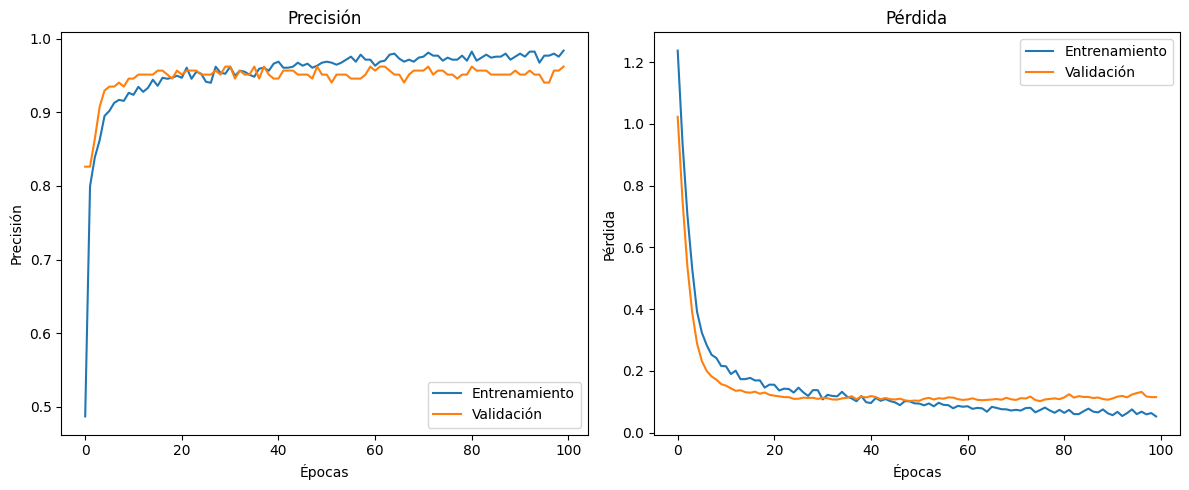

In [21]:
import matplotlib.pyplot as plt

# Gráfico de precisión y pérdida
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()
